# Prior Guided Denosing Framework

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## PreResNet

In [22]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.autograd import Variable

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # Skip the layer as necessary
        out = F.relu(out)
        return out
    
class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock."""

    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                )
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    """Pre-activation version of the original Bottleneck module."""

    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                )
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=100):
    return ResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes)


def ResNet34(num_classes=100):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)


def ResNet50(num_classes=100):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)


def ResNet101(num_classes=100):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)


def ResNet152(num_classes=100):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)
    
if __name__=="__main__":
    net = ResNet34()
    y = net(Variable(torch.randn(1, 3, 32, 32)))
    print(y.shape)

torch.Size([1, 100])


## Load Data

In [3]:
import os

os.chdir('./Yonsei-vnl-coding-assignment-vision-48hrs/dataset/')

In [5]:
from datasets import *

train_csv = 'data/cifar100_nl.csv'
test_csv = 'data/cifar100_nl_test.csv'
Dataloader = C100Dataset(train_csv, test_csv)
tr_x, tr_y, ts_x, ts_y = Dataloader.getDataset()
labels_map = Dataloader.getLabels_map()

print(tr_x.shape)
print(tr_y.shape)
print(ts_x.shape)
print(ts_y.shape)
print(labels_map)

(49999, 32, 32, 3)
(49999, 1)
(9999, 32, 32, 3)
(9999, 1)
{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'r

In [8]:
import torch
import matplotlib.pyplot as plt

In [155]:
tr_y.squeeze()

array([24., 95.,  0., ..., 36., 26., 69.])

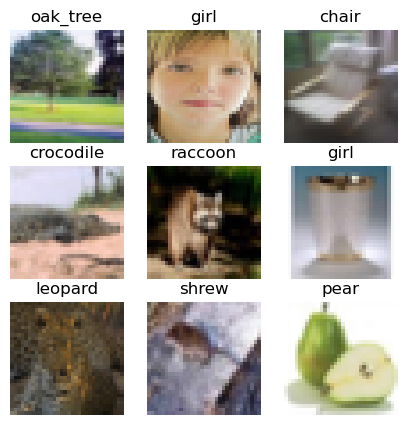

In [53]:
figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(tr_x), size=(1,)).item()
    img, label = tr_x[sample_idx], tr_y[sample_idx]
    img = img.astype('float32')/255
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[int(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preprocessing

In [189]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions.categorical as cat
import torch.distributions.dirichlet as diri
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchnet.meter import AUCMeter
from PIL import Image
import numpy as np
import sys

print(torch.backends.mps.is_built())
device = torch.device("mps")

True


In [156]:
class dataset(Dataset):
    def __init__(self, ts_x, ts_y, tr_x, tr_y, transform, mode, pred=[], probability=[]):
        self.transform = transform
        self.mode = mode
        
        if self.mode=='test':
            self.test_data = ts_x.astype(np.uint8)
            self.test_label = ts_y.squeeze().astype(np.uint8)
            
        else:
            if self.mode=='all':
                self.train_data = tr_x.astype(np.uint8)
                self.noise_label = tr_y.squeeze().astype(np.uint8)
                
            else:
                if self.mode == "labeled":
                    pred_idx = pred.nonzero()[0]
                    self.probability = [probability[i] for i in pred_idx]   
                    
                    clean = (np.array(noise_label)==np.array(train_label))                                                       
                    auc_meter = AUCMeter()
                    auc_meter.reset()
                    auc_meter.add(probability,clean)        
                    auc,_,_ = auc_meter.value()               
                    log.write('Numer of labeled samples:%d   AUC:%.3f\n'%(pred.sum(),auc))
                    log.flush()      
                    
                elif self.mode == "unlabeled":
                    pred_idx = (1-pred).nonzero()[0]                                               
                
                self.train_data = train_data[pred_idx]
                self.noise_label = [noise_label[i] for i in pred_idx]                          
                print("%s data has a size of %d"%(self.mode,len(self.noise_label)))
                
    def __getitem__(self, index):
        if self.mode=='labeled':
            img, target, prob = self.train_data[index], self.noise_label[index], self.probability[index]
            img = Image.fromarray(img)
            img1 = self.transform(img) 
            img2 = self.transform(img) 
            return img1, img2, target, prob 
        
        elif self.mode=='unlabeled':
            img = self.train_data[index]
            img = Image.fromarray(img)
            img1 = self.transform(img) 
            img2 = self.transform(img) 
            return img1, img2
        
        elif self.mode=='test':
            img, target = self.test_data[index], self.test_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            return img, target
        
        elif self.mode=='all':
            img, target = self.train_data[index], self.noise_label[index]
            img = Image.fromarray(img)
            img = self.transform(img)
            return img, target, index
        
    def __len__(self):
        if self.mode=='test':
            return len(self.test_data)
        elif self.mode=='all':
            return len(self.train_data)

class dataloader():
    def __init__(self, batch_size):
        self.batch_size = batch_size
        
        self.transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
            ])
        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276)),
            ])
    
    def run(self, mode, pred=[], prob=[]):
        if mode =='warmup':
            all_dataset = dataset(ts_x, ts_y, tr_x, tr_y, 
                                  transform=self.transform_train, 
                                  mode='all'
                                 )
            trainloader = DataLoader(dataset=all_dataset,
                                     batch_size=self.batch_size*2,
                                     shuffle=True
                                    )
            return trainloader
        
        elif mode=='train':
            labeled_dataset = dataset(ts_x, ts_y, tr_x, tr_y, 
                                      transform=self.transform_train, 
                                      mode="labeled", 
                                      pred=pred, probability=prob
                                     )
            labeled_trainloader = DataLoader(dataset=labeled_dataset,
                                     batch_size=self.batch_size,
                                     shuffle=True
                                    )
            
            unlabeled_dataset = dataset(ts_x, ts_y, tr_x, tr_y, 
                                        transform=self.transform_train, 
                                        mode="unlabeled", 
                                        pred=pred
                                       )
            unlabeled_trainloader = DataLoader(dataset=unlabeled_dataset,
                                               batch_size=self.batch_size,
                                               shuffle=True
                                              )
            return labeled_trainloader, unlabeled_trainloader
        
        elif mode=='test':
            test_dataset = dataset(ts_x, ts_y, tr_x, tr_y, 
                                   transform=self.transform_test, 
                                   mode="test", 
                                  )
            test_loader = DataLoader(dataset=test_dataset,
                                     batch_size=self.batch_size,
                                     shuffle=False
                                    )
            return test_loader
        
        elif mode=='eval_train':
            eval_dataset = dataset(ts_x, ts_y, tr_x, tr_y, 
                                   transform=self.transform_test, 
                                   mode="all", 
                                  )
            eval_loader = DataLoader(dataset=eval_dataset,
                                     batch_size=self.batch_size,
                                     shuffle=False
                                    )
            return eval_loader

In [157]:
batch_size = 64
lr = 0.02
noise_mode = 'sym'
alpha = 4
lambda_u = 25
p_threshold = 0.5
T = 0.5 # sharpening temperature
num_epochs = 300
r = 0.5 # noise ratio
num_class = 100

In [158]:
def train(epoch,
          net,
          net2,
          optimizer,
          labeled_trainloader,
          unlabeled_trainloader
         ):
    
    net.train()
    net2.eval() #fix one network and train the other
    
    unlabeled_train_iter = iter(unlabeled_trainloadr)
    num_iter = (len(tr_x)//batch_size)+1
    for batch_idx, (inputs_x, inputs_x2, labels_x, w_x) in enumerate(labeled_trainloader):      
        try:
            inputs_u, inputs_u2 = unlabeled_train_iter.next()
        except:
            unlabeled_train_iter = iter(unlabeled_trainloader)
            inputs_u, inputs_u2 = unlabeled_train_iter.next()                 
        batch_size = inputs_x.size(0)
        
        # Transform label to one-hot
        labels_x = torch.zeros(batch_size, args.num_class).scatter_(1, labels_x.view(-1,1), 1)        
        w_x = w_x.view(-1,1).type(torch.FloatTensor) 

        inputs_x, inputs_x2, labels_x, w_x = inputs_x.cuda(), inputs_x2.cuda(), labels_x.cuda(), w_x.cuda()
        inputs_u, inputs_u2 = inputs_u.cuda(), inputs_u2.cuda()

        with torch.no_grad():
            # label co-guessing of unlabeled samples
            outputs_u11 = net(inputs_u)
            outputs_u12 = net(inputs_u2)
            outputs_u21 = net2(inputs_u)
            outputs_u22 = net2(inputs_u2)            
            
            pu = (torch.softmax(outputs_u11, dim=1) + torch.softmax(outputs_u12, dim=1) + torch.softmax(outputs_u21, dim=1) + torch.softmax(outputs_u22, dim=1)) / 4       
            ptu = pu**(1/T) # temparature sharpening
            
            targets_u = ptu / ptu.sum(dim=1, keepdim=True) # normalize
            targets_u = targets_u.detach()       
            
            # label refinement of labeled samples
            outputs_x = net(inputs_x)
            outputs_x2 = net(inputs_x2)            
            
            px = (torch.softmax(outputs_x, dim=1) + torch.softmax(outputs_x2, dim=1)) / 2
            px = w_x*labels_x + (1-w_x)*px              
            ptx = px**(1/T) # temparature sharpening 
                       
            targets_x = ptx / ptx.sum(dim=1, keepdim=True) # normalize           
            targets_x = targets_x.detach()       
        
        # mixmatch
        l = np.random.beta(alpha, alpha)        
        l = max(l, 1-l)
                
        all_inputs = torch.cat([inputs_x, inputs_x2, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x, targets_x, targets_u, targets_u], dim=0)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]
        
        mixed_input = l * input_a + (1 - l) * input_b        
        mixed_target = l * target_a + (1 - l) * target_b
                
        logits = net(mixed_input)
        logits_x = logits[:batch_size*2]
        logits_u = logits[batch_size*2:]        
           
        Lx, Lu, lamb = criterion(logits_x, mixed_target[:batch_size*2], logits_u, mixed_target[batch_size*2:], epoch+batch_idx/num_iter, warm_up)
        
        # regularization
        prior = torch.ones(args.num_class)/args.num_class
        prior = prior.cuda()        
        pred_mean = torch.softmax(logits, dim=1).mean(0)
        penalty = torch.sum(prior*torch.log(prior/pred_mean))

        loss = Lx + lamb * Lu  + penalty
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        """
        sys.stdout.write('\r')
        sys.stdout.write('%s:%.1f-%s | Epoch [%3d/%3d] Iter[%3d/%3d]\t Labeled loss: %.2f  Unlabeled loss: %.2f'
                %(args.dataset, args.r, args.noise_mode, epoch, args.num_epochs, batch_idx+1, num_iter, Lx.item(), Lu.item()))
        sys.stdout.flush()
        """

In [182]:
def warmup(epoch,net,optimizer,dataloader):
    net.train()
    num_iter = (len(dataloader.dataset)//dataloader.batch_size)+1
    for batch_idx, (inputs, labels, path) in enumerate(dataloader):      
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = CEloss(outputs, labels)          
        L = loss
        L.backward()  
        optimizer.step() 

        sys.stdout.write('\r')
        sys.stdout.write('Epoch [%3d/%3d] Iter[%3d/%3d]\t CE-loss: %.4f'
                %(epoch, num_epochs, batch_idx+1, num_iter, loss.item()))
        sys.stdout.flush()

In [183]:
def test(epoch,net1,net2):
    net1.eval()
    net2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs1 = net1(inputs)
            outputs2 = net2(inputs)           
            outputs = outputs1+outputs2
            _, predicted = torch.max(outputs, 1)            
                       
            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()                 
    acc = 100.*correct/total
    print("\n| Test Epoch #%d\t Accuracy: %.2f%%\n" %(epoch,acc))
    """
    test_log.write('Epoch:%d   Accuracy:%.2f\n'%(epoch,acc))
    test_log.flush()
    """

In [184]:
def eval_train(model,all_loss):    
    model.eval()
    losses = torch.zeros(49999)    
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(eval_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) 
            loss = CE(outputs, targets)  
            for b in range(inputs.size(0)):
                losses[index[b]]=loss[b]         
    losses = (losses-losses.min())/(losses.max()-losses.min())    
    all_loss.append(losses)

    if args.r==0.9: # average loss over last 5 epochs to improve convergence stability
        history = torch.stack(all_loss)
        input_loss = history[-5:].mean(0)
        input_loss = input_loss.reshape(-1,1)
    else:
        input_loss = losses.reshape(-1,1)
    
    # fit a two-component GMM to the loss
    gmm = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm.fit(input_loss)
    prob = gmm.predict_proba(input_loss) 
    prob = prob[:,gmm.means_.argmin()]         
    return prob,all_loss

In [185]:
def linear_rampup(current, warm_up, rampup_length=16):
    current = np.clip((current-warm_up) / rampup_length, 0.0, 1.0)
    return args.lambda_u*float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, warm_up):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, linear_rampup(epoch,warm_up)

class NegEntropy(object):
    def __call__(self,outputs):
        probs = torch.softmax(outputs, dim=1)
        return torch.mean(torch.sum(probs.log()*probs, dim=1))

def create_model():
    model = ResNet34(num_classes=1000)
    model = model.to(device)
    return model

In [186]:
import torch.backends.cudnn as cudnn
import torch.optim as optim

In [ ]:
warm_up = 30

loader = dataloader(batch_size=batch_size)

print('| Building net')
net1 = create_model()
net2 = create_model()
cudnn.benchmark = True

criterion = SemiLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

CE = nn.CrossEntropyLoss(reduction='none')
CEloss = nn.CrossEntropyLoss()

all_loss = [[],[]] # save the history of losses from two networks

for epoch in range(num_epochs+1):   
    lr=lr
    if epoch >= 150:
        lr /= 10      
    for param_group in optimizer1.param_groups:
        param_group['lr'] = lr       
    for param_group in optimizer2.param_groups:
        param_group['lr'] = lr          
    test_loader = loader.run('test')
    eval_loader = loader.run('eval_train')
    
    if epoch<warm_up:       
        warmup_trainloader = loader.run('warmup')
        print('Warmup Net1')
        warmup(epoch,net1,optimizer1,warmup_trainloader)    
        print('\nWarmup Net2')
        warmup(epoch,net2,optimizer2,warmup_trainloader) 
    
    else:         
        prob1,all_loss[0]=eval_train(net1,all_loss[0])   
        prob2,all_loss[1]=eval_train(net2,all_loss[1])          
               
        pred1 = (prob1 > p_threshold)      
        pred2 = (prob2 > p_threshold)      
        
        print('Train Net1')
        labeled_trainloader, unlabeled_trainloader = loader.run('train',pred2,prob2) # co-divide
        train(epoch,net1,net2,optimizer1,labeled_trainloader, unlabeled_trainloader) # train net1  
        
        print('\nTrain Net2')
        labeled_trainloader, unlabeled_trainloader = loader.run('train',pred1,prob1) # co-divide
        train(epoch,net2,net1,optimizer2,labeled_trainloader, unlabeled_trainloader) # train net2         

    test(epoch,net1,net2)  

| Building net
Warmup Net1
Epoch [  0/300] Iter[391/391]	 CE-loss: 5.3660
Warmup Net2
Epoch [  0/300] Iter[391/391]	 CE-loss: 5.8536
| Test Epoch #0	 Accuracy: 2.15%

Warmup Net1
Epoch [  1/300] Iter[391/391]	 CE-loss: 5.0973
Warmup Net2
Epoch [  1/300] Iter[159/391]	 CE-loss: 5.4508